In [1]:
import pandas as pd

In [2]:
df_b = pd.read_csv('Data/us/Bundesliga.csv')
df_e = pd.read_csv('Data/us/EPL.csv')
df_l = pd.read_csv('Data/us/La_Liga.csv')
df_s = pd.read_csv('Data/us/Serie_A.csv')
df_1 = pd.read_csv('Data/us/Ligue_1.csv')
df_r = pd.read_csv('Data/us/RFPL.csv')

In [23]:
# concatenate all the dataframes
df = pd.concat([df_b, df_e, df_l, df_s, df_1, df_r])

In [24]:
dfs = df[['id','player_id','match_id','season','X','Y','xG','shotType','situation','lastAction','result']]

In [25]:
df.groupby('situation').size()

situation
DirectFreekick     159335
FromCorner         539932
OpenPlay          2729945
Penalty             50778
SetPiece           224556
dtype: int64

In [26]:
df.groupby('shotType').size()

shotType
Head              610491
LeftFoot         1169672
OtherBodyPart      14238
RightFoot        1910145
dtype: int64

In [27]:
df.groupby('lastAction').size()

lastAction
Aerial              268784
BallRecovery         85929
BallTouch            65900
BlockedPass           4752
Card                   916
Challenge             1536
ChanceMissed            21
Chipped             186642
Claim                   10
Clearance             1465
CornerAwarded         6018
Cross               505710
CrossNotClaimed         21
Dispossessed         20223
End                   2697
Error                  103
FormationChange        146
Foul                  6461
Goal                  2571
GoodSkill              621
HeadPass             85507
Interception          3892
KeeperPickup           204
KeeperSweeper           29
LayOff               28893
OffsidePass            963
OffsideProvoked        191
Pass               1351554
PenaltyFaced            12
Punch                   61
Rebound             162046
Save                   725
ShieldBallOpp           42
Smother                  5
Standard            210113
Start                  145
SubstitutionOff  

In [28]:
# convert columns to dummy variables
cols = ['shotType','situation']
dfs = pd.get_dummies(df, columns=cols)
dfs.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,season,...,lastAction,shotType_Head,shotType_LeftFoot,shotType_OtherBodyPart,shotType_RightFoot,situation_DirectFreekick,situation_FromCorner,situation_OpenPlay,situation_Penalty,situation_SetPiece
0,24501,71,SavedShot,0.868,0.461,0.026551,Alexander Meier,h,356,2014,...,Aerial,True,False,False,False,False,False,True,False,False
1,25008,82,BlockedShot,0.880,0.386,0.072646,Alexander Meier,h,356,2014,...,Pass,False,False,False,True,False,False,True,False,False
2,25026,3,MissedShots,0.947,0.623,0.033752,Alexander Meier,a,356,2014,...,Cross,True,False,False,False,False,False,True,False,False
3,25028,14,Goal,0.970,0.384,0.073383,Alexander Meier,a,356,2014,...,NaN,False,False,False,True,False,True,False,False,False
4,25041,75,MissedShots,0.938,0.516,0.127458,Alexander Meier,a,356,2014,...,Cross,True,False,False,False,False,True,False,False,False


In [29]:
# Convert the result column to a binary outcome
dfs['result'] = dfs['result'].apply(lambda x: 1 if x == 'Goal' else 0)

In [30]:
X = ['X','Y','shotType_Head','shotType_LeftFoot','shotType_OtherBodyPart','shotType_RightFoot','situation_DirectFreekick',
     'situation_FromCorner','situation_OpenPlay','situation_Penalty','situation_SetPiece']

In [31]:
# convert boolean columns to integers
dfs[X[2:]] = dfs[X[2:]].astype(int)

In [32]:
dfs = dfs[dfs['match_id']!=22854]

In [33]:
dfs.reset_index(drop=True, inplace=True)

In [34]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_data = dfs[X]
y_data = dfs['result']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42,stratify=y_data)

In [35]:
# train a logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

# evaluate the model
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
# 0.8973019665006546

0.8971377821928643

In [40]:
# round xG to 0 or 1
dfs['xGoal'] = dfs['xG'].apply(lambda x: 1 if x >= 0.5 else 0)

In [43]:
from sklearn.metrics import accuracy_score

# Ensure the xGoal column matches the indices of X_test
xGoal_test = dfs.loc[X_test.index, 'xGoal']

# Calculate the accuracy of your predictions against xGoal
matching_accuracy = accuracy_score(xGoal_test, y_pred)

print(f"Matching accuracy with xGoal: {matching_accuracy}")


Matching accuracy with xGoal: 0.9604315867047108


In [44]:
# Add the test indices to the original DataFrame
dfs_test = dfs.iloc[X_test.index]

# Calculate the matching rate
from sklearn.metrics import accuracy_score

matching_rate = accuracy_score(dfs_test['xGoal'], y_pred)
print("Matching Rate:", matching_rate)

Matching Rate: 0.9604315867047108


In [42]:
# calculate accuracy of our model against xGoal
accuracy_score(dfs['result'], dfs['xGoal'])

0.9034962124095619

In [16]:
# compare the probability of the model with xg in dfs
dfs['xG_pred'] = model.predict_proba(X_data)[:,1]
dfs[['xG','xG_pred']]

/tmp/ipykernel_33200/891525737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['xG_pred'] = model.predict_proba(X_data)[:,1]


,xG,xG_pred
0,0.026551,0.069881
1,0.072646,0.131470
2,0.033752,0.177678
3,0.073383,0.235895
4,0.127458,0.105017
...,...,...
3704461,0.015292,0.013022
3704462,0.010113,0.010513
3704463,0.009143,0.006772
3704464,0.012087,0.039857


In [17]:
# confirm the model is not overfitting
y_pred_train = model.predict(X_train)
accuracy_score(y_train, y_pred_train)
# 0.8970800826067004

0.8970856790386736

In [19]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    658912
           1       0.78      0.10      0.17     81982

    accuracy                           0.90    740894
   macro avg       0.84      0.55      0.56    740894
weighted avg       0.89      0.90      0.86    740894



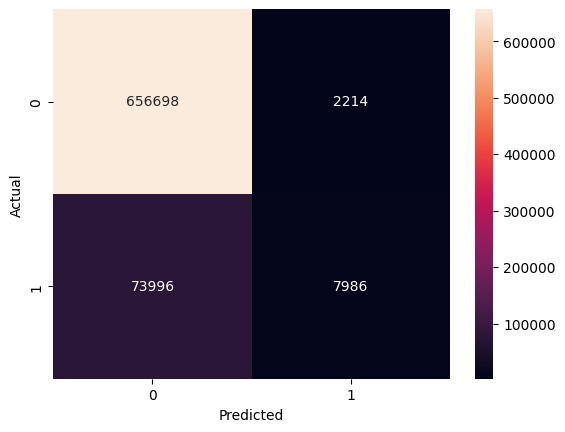

In [20]:
# confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
dfs.drop(columns=['xG_pred','rmse'], inplace=True)
dfs

,id,player_id,match_id,season,X,Y,xG,lastAction,result,shotType_Head,shotType_LeftFoot,shotType_OtherBodyPart,shotType_RightFoot,situation_DirectFreekick,situation_FromCorner,situation_OpenPlay,situation_Penalty,situation_SetPiece
0,24501,356,5451,2014,0.868,0.461,0.026551,Aerial,0,1,0,0,0,0,0,1,0,0
1,25008,356,5418,2014,0.880,0.386,0.072646,Pass,0,0,0,0,1,0,0,1,0,0
2,25026,356,5423,2014,0.947,0.623,0.033752,Cross,0,1,0,0,0,0,0,1,0,0
3,25028,356,5423,2014,0.970,0.384,0.073383,NaN,1,0,0,0,1,0,1,0,0,0
4,25041,356,5423,2014,0.938,0.516,0.127458,Cross,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364352,596376,13121,26447,2024,0.734,0.431,0.015292,Pass,0,0,0,0,1,0,1,0,0,0
364353,598940,13121,26458,2024,0.681,0.750,0.010113,Pass,0,0,0,0,1,0,0,1,0,0
364354,597767,13163,26450,2024,0.648,0.288,0.009143,Pass,0,0,0,0,1,0,0,1,0,0
364355,603365,13230,26489,2024,0.789,0.226,0.012087,Challenge,0,0,1,0,0,0,0,1,0,0


In [52]:
dfs.to_csv('Data/us/shot_logs.csv', index=False)

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('soccer').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 07:31:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
r = spark.read.csv('understat/understat.csv', header=True, inferSchema=True)

In [4]:
r.show()

+------+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+-------------------+
|    id|player_id|   shot_location_x|   shot_location_y| lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|situation_DirectFreekick|situation_FromCorner|situation_OpenPlay|situation_Penalty|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|
+------+---------+------------------+------------------+-----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+-------------------+
|

In [5]:
features = ['header','shotType_OtherBodyPart','situation_DirectFreekick','situation_FromCorner',
            'situation_OpenPlay','situation_Penalty','situation_SetPiece','distance_to_goal','shot_angle','preferred_foot_shot']

In [6]:
# using these features train a logistic regression model
from xG_training import ModelTrainer
import xG_preprocessing as xG_pre

In [7]:
train_data, test_data = xG_pre.pre_training(r, features,0.7)

In [8]:
log_reg = ModelTrainer(train_data,test_data,max_iter=100)

25/01/28 07:32:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [9]:
from xG_evaluation import ModelEvaluation
from pyspark.sql.functions import col, when

In [10]:
predictions = log_reg.predictions
predictions = xG_pre.goal_proba(predictions)
predictions = predictions.withColumn('sb_prediction', when(col('xG') >= 0.5, 1).otherwise(0))
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'xG','goal_probability',model_type='regression')

In [11]:
predictions.show()

25/01/28 07:35:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+------------------+------------------+----------+------+-----------------+----------------------+------------------+------------------------+--------------------+------------------+-----------------+------------------+----+------------------+----------------+------------------+--------------+-------------------+--------------------+--------------------+--------------------+----------+----------------+-------------+
| id|player_id|   shot_location_x|   shot_location_y|lastAction|header|shotType_LeftFoot|shotType_OtherBodyPart|shotType_RightFoot|situation_DirectFreekick|situation_FromCorner|situation_OpenPlay|situation_Penalty|situation_SetPiece|goal|                xG|distance_to_goal|        shot_angle|preferred_foot|preferred_foot_shot|     features_vector|       rawPrediction|         probability|prediction|goal_probability|sb_prediction|
+---+---------+------------------+------------------+----------+------+-----------------+----------------------+------------------+-

In [15]:
from pyspark.sql.functions import col,lit,when

In [50]:
thresholds = [i / 100.0 for i in range(101)]

In [ ]:
def precision_recall(predictions,threshold_step=0.01):
    thresholds = [i for i in range(0,1,threshold_step)]
    precision = []
    recall = []
    for threshold in thresholds:
        if threshold % 0.2 ==0:
            print(threshold)
        df_pr = predictions.withColumn("predicted",
                                    when(col("goal_probability")>=lit(threshold),
                                            lit(1)).otherwise(lit(0)))

        TP = df_pr.filter((col('predicted')==1)& (col("goal")==1)).count()
        FP = df_pr.filter((col('predicted')==1)& (col("goal")==0)).count()
        FN = df_pr.filter((col('predicted')==0)& (col("goal")==1)).count()

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec  = TP / (TP + FN) if (TP + FN) > 0 else 0

        precision.append(prec)
        recall.append(rec)

    return precision, recall

In [44]:
p = predictions.dropDuplicates()

In [46]:
p.cache 

<bound method DataFrame.cache of DataFrame[id: int, player_id: int, shot_location_x: double, shot_location_y: double, lastAction: string, header: int, shotType_LeftFoot: int, shotType_OtherBodyPart: int, shotType_RightFoot: int, situation_DirectFreekick: int, situation_FromCorner: int, situation_OpenPlay: int, situation_Penalty: int, situation_SetPiece: int, goal: int, xG: double, distance_to_goal: double, shot_angle: double, preferred_foot: string, preferred_foot_shot: int, features_vector: vector, rawPrediction: vector, probability: vector, prediction: double, goal_probability: double, sb_prediction: int]>

In [ ]:
precision = []
recall = []
for threshold in thresholds:
    if threshold % 0.1 == 0:
        print(threshold)
    df_pr = p.withColumn("predicted",
                                   when(col("goal_probability")>=lit(threshold),
                                        lit(1)).otherwise(lit(0)))
    TP = df_pr.filter((col('predicted')==1)& (col("sb_prediction")==1)).count()
    FP = df_pr.filter((col('predicted')==1)& (col("sb_prediction")==0)).count()
    FN = df_pr.filter((col('predicted')==0)& (col("sb_prediction")==1)).count()

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    precision.append(prec)
    recall.append(rec)

0.0
0.2
0.4
0.8


In [93]:
precision = precision[0:-2]
recall = recall[0:-2]

In [95]:
precision

[0.051568844592100406,
 0.05226291443485456,
 0.05583611937912323,
 0.06323825449742776,
 0.07206865473260644,
 0.08176919236265344,
 0.09264151017015947,
 0.10532293413545576,
 0.12057328725350681,
 0.13713224230920582,
 0.1549050425671251,
 0.17571532835843126,
 0.19952112891311546,
 0.22532554401701588,
 0.25204228476212115,
 0.2799203571859539,
 0.30785729510817433,
 0.3355686108721956,
 0.36243394614435337,
 0.38908991602375914,
 0.4164369463740949,
 0.44300232402410683,
 0.47123091200539946,
 0.49806576402321084,
 0.5262299016078714,
 0.5538092565188549,
 0.580835407423439,
 0.6079724691712074,
 0.6326512078464612,
 0.6562718990889979,
 0.6798445456982042,
 0.7036827994920276,
 0.7236283022353593,
 0.7427289603960396,
 0.7605736509479825,
 0.7786098066590514,
 0.7951759238769639,
 0.8077984182453559,
 0.8207420866405278,
 0.8330927373189307,
 0.8445900624322791,
 0.8551970943275291,
 0.8643357414658358,
 0.8745084629851256,
 0.8834030519059684,
 0.8908671082214256,
 0.89883560786

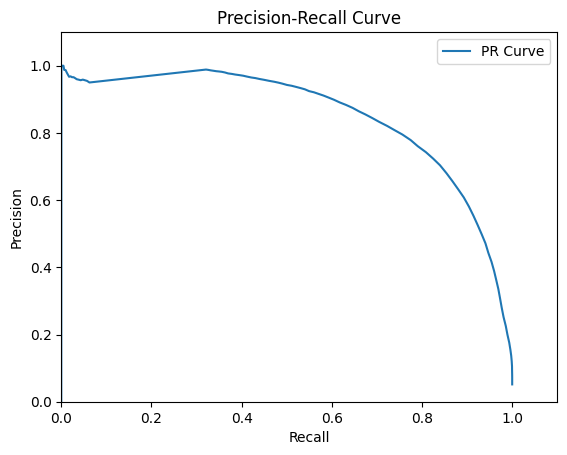

In [96]:
plt.plot(recall, precision, label="PR Curve")
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

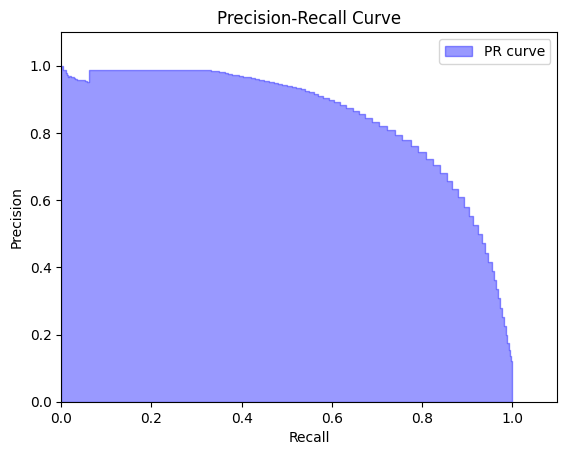

In [99]:
plt.fill_between(recall,precision, step='post',alpha=0.4,color='blue',label='PR curve')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [100]:
me.get_all_metrics()

{'Accuracy': 90.11,
 'Precision': 67.69,
 'Recall': 19.87,
 'Sensitivity': 19.87,
 'Specificity': 98.82,
 'F1': 30.72,
 'FPR': 1.18,
 'FNR': 80.13}

In [101]:
me_sb.get_all_metrics()

{'Accuracy': 97.42,
 'Precision': 92.15,
 'Recall': 56.14,
 'Sensitivity': 56.14,
 'Specificity': 99.73,
 'F1': 69.78,
 'FPR': 0.27,
 'FNR': 43.86}

In [102]:
me_r.get_all_metrics()

{'MSE': 0.00771, 'RMSE': 0.0878, 'MAE': 0.04849, 'R2': 71.59}